# Expected change in albedo from cloud brightening / thickening



## Fitting a function

If we scatter plot albedo versus logarithmic total column integrated cloud water we see a clear sigmoid relationship. Here I try to fit a sigmoid function to this point cloud. I went with a scaled cumulative distribution function (CDF) for a log-normal distribution, adjusted to have minimal and maximal values as parameter. This is based on the assumption that albedo is caused by multiple scattering events, where light is scattered by droplets. Cloud droplet sizes often follow a log-normal distribution (e.g. 10.5194/amt-16-645-2023). With reflectivity being a cumulative effect of scattering, this make the log-normal CDF a good choice to approximate the *total column integrated cloud water* - *albedo* relationship.

$$
f(x) = y_{\text{min}} + (y_{\text{max}} - y_{\text{min}}) \cdot \frac{1}{2} \left( 1 + \text{erf} \left( \frac{\log(x) - \mu}{\sigma \sqrt{2}} \right) \right)
$$

In a first attempt I tried to automatically fit a function to the data, but the results are not convincing. The fit could be improved by preprocessing the input data. Instead I hand fitted a function.

In [20]:
import sys
import os
import scipy.optimize

module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import xarray as xr
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt

fh.disable_warnings()

def add_albedo(dataset):
    dataset['albedo'] = dataset['sou_t'] / dataset['sod_t']
    return dataset
    
def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , 'DOM01'])), 
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01']))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)
    data = add_albedo(data)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = data.sel(time=slice(pd.to_datetime('2020-01-11-10:00'), pd.to_datetime('2020-01-12-10:00')))
    return data

def log_normal_cdf_scaled(x, mu, sigma, y_min, y_max):
    """
    Computes a scaled cumulative distribution function (CDF) for a log-normal distribution.

    This function calculates the CDF of a log-normal distribution for the input array `x`,
    scales the result to fit within the range `[y_min, y_max]`, and handles non-positive
    values of `x` by setting them to `y_min`.

    Parameters:
    - x (array-like): Input values for which to compute the scaled CDF.
    - mu (float, optional): The mean of the underlying normal distribution of the log-normal.
    - sigma (float, optional): The standard deviation of the underlying normal distribution.
    - y_min (float, optional): The minimum value of the scaled CDF.
    - y_max (float, optional): The maximum value of the scaled CDF.

    Returns:
    - numpy.ndarray: The scaled CDF values corresponding to the input `x`, with non-positive
      `x` values set to `y_min`.
    """
    x = np.asarray(x)
    scaled_log = (np.log(x) - mu) / (sigma * np.sqrt(2))
    cumulative_distribution = 0.5 * (1 + scipy.special.erf(scaled_log))
    normalized_values = y_min + (y_max - y_min) * cumulative_distribution
    normalized_values[x <= 0] = y_min  # Handle non-positive x values
    return normalized_values

def fig_fit_logistic_to_xarray(data):
    # Reduce amount of data for faster plotting
    data = data.isel(time=slice(None, None, 2))
    x = np.ravel(data['tqc_dia'].values)[::4**5]
    y = np.ravel(data['albedo'].values)[::4**5]

    # remove Nan, remove inF and sort for scipy.optimize.curve_fit
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
    x = x[mask]
    y = y[mask]

    # initial guess
    mu    = 1
    sigma = 1
    y_min = 0
    y_max = 1
    popt, pcov = scipy.optimize.curve_fit(log_normal_cdf_scaled, x, y, p0=[mu, sigma, y_min, y_max])
    mu, sigma, y_min, y_max = popt
    label = f'$f(x) = {y_min:.2} + \\frac{{{y_max:.2} - {y_min:.2}}}{{2}} \\left(1 + \\text{{erf}}\\left(\\frac{{\\log({np.exp(mu):.2})x}}{{{sigma:.2} \\sqrt{{2}}}}\\right)\\right)$'
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x_space = np.linspace(np.nanmin(x), np.nanmax(x), 10000)
    ax.plot(x_space, log_normal_cdf_scaled(x_space, mu, sigma, y_min, y_max), label=label, color='red')
    kwargs = {'marker':'.', 'color':'black', 's':4, 'alpha':0.1}
    ax.scatter(x, y, label='Data', **kwargs)
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel(f'{data["tqc_dia"].attrs["long_name"]} / {data["tqc_dia"].attrs["units"]}')
    ax.set_ylabel(f'albedo')
    ax.set_title('log normal CDF, automatically fitted')
    return fig, ax

data = get_data()
data = pp.filter_by_threshold(data, {'clct':0.5})
fig, ax = fig_fit_logistic_to_xarray(data)
fig.show()

Any code that generates warnings will no longer print them to the console.


In [21]:
def fig_fixedfit_logistic_to_xarray(data):
    # Reduce amount of data for faster plotting
    data = data.isel(time=slice(None, None, 2))
    x = np.ravel(data['tqc_dia'].values)[::4**5]
    y = np.ravel(data['albedo'].values)[::4**5]

    # remove Nan, remove inF and sort for scipy.optimize.curve_fit
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
    x = x[mask]
    y = y[mask]

    # initial guess
    mu    = np.log(1e-1)
    sigma = 1.7
    y_min = 0.1
    y_max = 0.7
    label = f'$f(x) = {y_min:.2} + \\frac{{{y_max:.2} - {y_min:.2}}}{{2}} \\left(1 + \\text{{erf}}\\left(\\frac{{\\log({np.exp(mu):.2})x}}{{{sigma:.2} \\sqrt{{2}}}}\\right)\\right)$'
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x_space = np.linspace(np.nanmin(x), np.nanmax(x), 10000)
    ax.plot(x_space, log_normal_cdf_scaled(x_space, mu, sigma, y_min, y_max), label=label, color='red')
    kwargs = {'marker':'.', 'color':'black', 's':4, 'alpha':0.1}
    ax.scatter(x, y, label='Data', **kwargs)
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel(f'{data["tqc_dia"].attrs["long_name"]} / {data["tqc_dia"].attrs["units"]}')
    ax.set_ylabel(f'albedo')
    ax.set_title('log normal CDF, manually fitted')
    return fig, ax

data = get_data()
data = pp.filter_by_threshold(data, {'clct':0.5})
fig, ax = fig_fixedfit_logistic_to_xarray(data)
fig.show()

In [2]:
def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , 'DOM01'])), 
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01']))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)
    
    data = add_control(data)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = add_albedo(data)
    return data
    
def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))
    
    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

data = get_data()
data = data.isel({'time':slice(None, None, 100), 'cell':slice(None, None, 500)})
data

<xarray.Dataset> Size: 8MB
Dimensions:        (cell: 4310, exp: 2, time: 12)
Coordinates:
    lat            (cell) float64 34kB 9.501 9.651 9.617 ... 13.12 12.98 12.92
    lon            (cell) float64 34kB -47.75 -47.83 -48.09 ... -51.37 -51.36
  * cell           (cell) int64 34kB 396191 398784 404385 ... 4469138 4469638
  * time           (time) datetime64[ns] 96B 2020-01-09T10:00:00 ... 2020-01-...
  * exp            (exp) object 16B 'warming' 'control'
Data variables: (12/20)
    tqv_dia        (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    pres_sfc       (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    thb_t          (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 1812), meta=np.ndarray>
    rh_2m          (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    t_2m           (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    sou_t          (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 1812), meta=np.ndarray>
    ...             ...
    tqi_dia        (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    tqc_dia        (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    lhfl_s         (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    shfl_s         (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 504), meta=np.ndarray>
    sob_t          (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 1812), meta=np.ndarray>
    albedo         (exp, time, cell) float32 414kB dask.array<chunksize=(1, 1, 1812), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

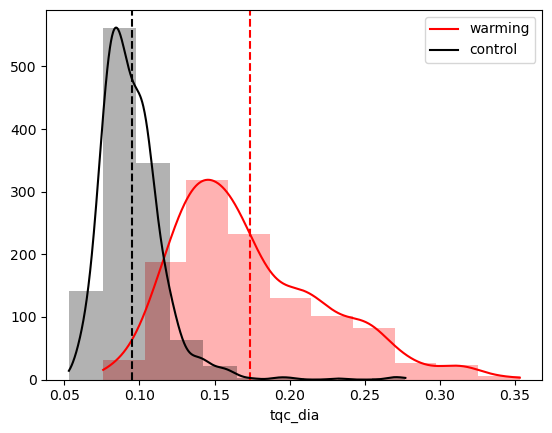

In [3]:
import plot_utils as pu
import importlib; importlib.reload(pu)

def plot_hist_comparison(var):
    data = get_data()
    data = data.isel({'cell':slice(None, None, 500)})
    fig, ax = plt.subplots()
    kwargs = [ {'label': 'control', 'color': 'black'},
               {'label': 'warming', 'color': 'red'} ]
    for exp in data.exp.values:
        kws = {'label':exp}
        kws['color'] = 'black' if exp == 'control' else 'red'
        d = data.sel(exp=exp)
        d = pp.filter_by_threshold(d, {'tqc_dia':1e-4}, False)
        d = d.mean(dim='cell')
        ax = pu.ax_histogram(ax, d, var, **kws)
    fig.show()

plot_hist_comparison('tqc_dia')

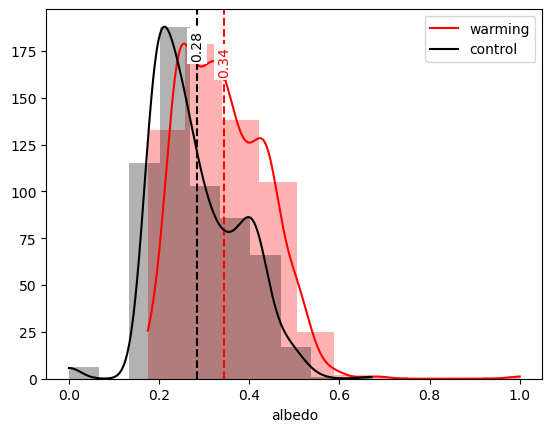

In [24]:
plot_hist_comparison('albedo')

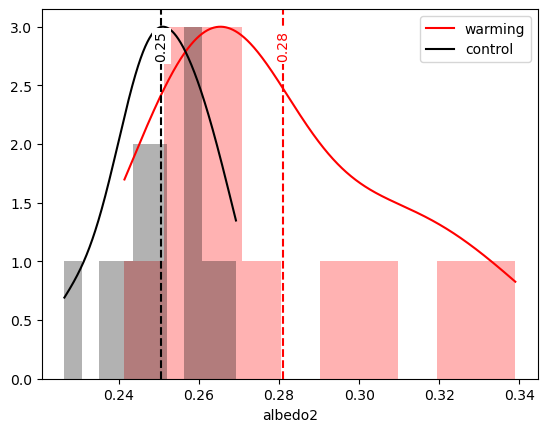

In [20]:
import importlib; importlib.reload(pu)

def plot_albedo2_hist_comparison():
    data = get_data()
    data = data.isel({'time':slice(None, None, 100), 'cell':slice(None, None, 500)})
    dims = data['tqc_dia'].dims
    data['albedo2'] = (dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    var = 'albedo2'
    # data = data.isel({'cell':slice(None, None, 500)})
    fig, ax = plt.subplots()
    kwargs = [ {'label': 'control', 'color': 'black'},
               {'label': 'warming', 'color': 'red'} ]
    for exp in data.exp.values:
        kws = {'label':exp}
        kws['color'] = 'black' if exp == 'control' else 'red'
        d = data.sel(exp=exp)
        d = pp.filter_by_threshold(d, {'tqc_dia':1e-4}, False)
        d = d.mean(dim='cell')
        ax = pu.ax_histogram(ax, d, var, **kws)
    fig.show()
    
plot_albedo2_hist_comparison()

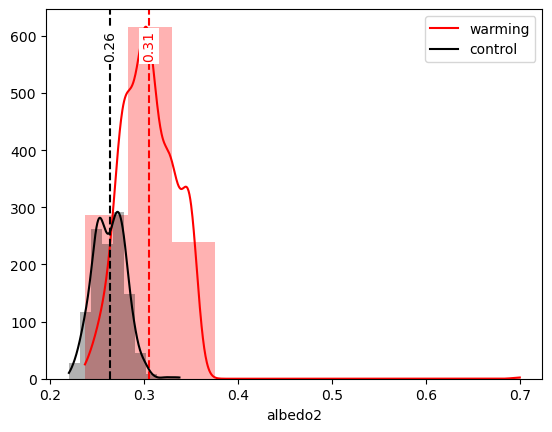

In [21]:
def get_some_data():
    data = get_data()
    data = pp.filter_by_threshold(data, {'clct':0.5})
    data = data.isel({'time':slice(None, None, None), 'cell':slice(None, None, 500)})
    data['estimated albedo'] = (data['tqc_dia'].dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    return data

def plot_albedo2_hist_comparison():
    var = 'estimated albedo'
    data = get_some_data()
    data[var] = (data['tqc_dia'].dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    
    fig, ax = plt.subplots()
    kwargs = [ {'label': 'control', 'color': 'black'},
               {'label': 'warming', 'color': 'red'} ]
    for exp in data.exp.values:
        kws = {'label':exp}
        kws['color'] = 'black' if exp == 'control' else 'red'
        d = data.sel(exp=exp)
        d = pp.filter_by_threshold(d, {'tqc_dia':1e-4}, False)
        d = d.mean(dim='cell')
        ax = pu.ax_histogram(ax, d, var, **kws)
    fig.show()
    
plot_albedo2_hist_comparison()

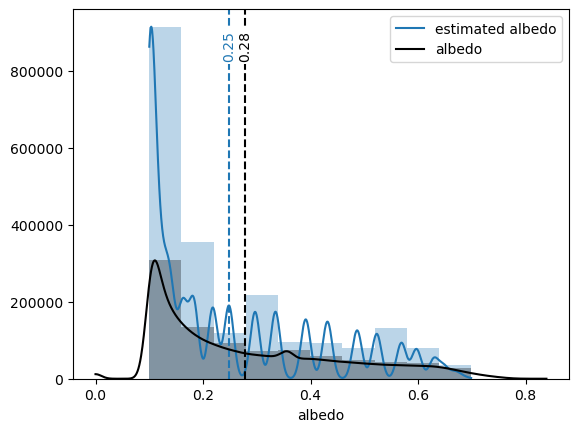

In [22]:

def fixedfig_albedo2_hist_comparison(exp='control'):
    bins=None
    kwargs = dict()
    hist_kwargs = kwargs.copy()
    label = hist_kwargs.pop('label', 'KDE')
    color = hist_kwargs.pop('color', 'blue')
    
    # data = get_data()
    # data = pp.filter_by_threshold(data, {'clct':0.5})
    # data = data.isel({'time':slice(None, None, None), 'cell':slice(None, None, 500)})
    # data['estimated albedo'] = (data['tqc_dia'].dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    # data = data.sel(exp=exp)
    
    dataset = get_some_data().sel(exp=exp)
    
    fig, ax = plt.subplots()
    
    for varname, color in zip(['estimated albedo', 'albedo'], ['tab:blue', 'black']):
        label = varname
        values = np.ravel(dataset[varname])
        values = values[np.isfinite(values) & ~np.isnan(values)]   # Drop NaN and inf
        counts, bins, patches = ax.hist(values, bins=bins, alpha=.3, color=color, **hist_kwargs)
        hist_max = max(counts)
        kde = scipy.stats.gaussian_kde(values)
        x = np.linspace(min(values), max(values), 1000)
        y = kde(x)
        y = y * (hist_max / max(y))  # Rescale KDE to match histogram
        mean_value = np.nanmean(values)
    
        ax.axvline(np.nanmean(values), color=color, ls='--')
        ax.plot(x, y, label=label, color=color)
        ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'{mean_value:.2f}', color=color, 
                ha='center', va='center', rotation=90, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        
    xlabel = dataset[varname].attrs.get('long_name', varname)
    if 'units' in dataset[varname].attrs:
        xlabel += ' / ' + dataset[varname].attrs['units']
    ax.set_xlabel(xlabel)
    ax.legend()
    
    return fig, ax

fig, ax = fixedfig_albedo2_hist_comparison()
fig.show()

In [23]:
fig, ax = fixedfig_albedo2_hist_comparison('warming')
fig.show()

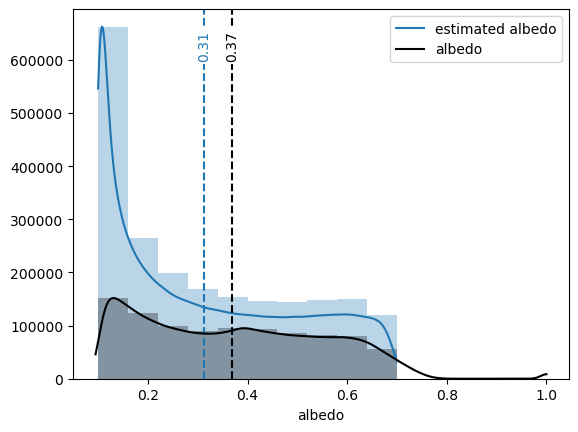

In [27]:
def get_some_data():
    data = get_data()
    data = pp.filter_by_threshold(data, {'clct':0.5})
    data = data.isel({'time':slice(None, None, None), 'cell':slice(None, None, 500)})
    data['estimated albedo'] = (data['tqc_dia'].dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    return data

def fixedfig_albedo2_hist_comparison(exp='control'):
    bins=None
    kwargs = dict()
    hist_kwargs = kwargs.copy()
    label = hist_kwargs.pop('label', 'KDE')
    color = hist_kwargs.pop('color', 'blue')
    
    dataset = get_some_data().sel(exp=exp)
    dataset = pp.filter_by_threshold(dataset, {'tqc_dia':1e-4}, False)
    
    fig, ax = plt.subplots()
    
    for varname, color in zip(['estimated albedo', 'albedo'], ['tab:blue', 'black']):
        label = varname
        values = np.ravel(dataset[varname])
        values = values[np.isfinite(values) & ~np.isnan(values)]   # Drop NaN and inf
        counts, bins, patches = ax.hist(values, bins=bins, alpha=.3, color=color, **hist_kwargs)
        hist_max = max(counts)
        kde = scipy.stats.gaussian_kde(values)
        x = np.linspace(min(values), max(values), 1000)
        y = kde(x)
        y = y * (hist_max / max(y))  # Rescale KDE to match histogram
        mean_value = np.nanmean(values)
    
        ax.axvline(np.nanmean(values), color=color, ls='--')
        ax.plot(x, y, label=label, color=color)
        ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'{mean_value:.2f}', color=color, 
                ha='center', va='center', rotation=90, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        
    xlabel = dataset[varname].attrs.get('long_name', varname)
    if 'units' in dataset[varname].attrs:
        xlabel += ' / ' + dataset[varname].attrs['units']
    ax.set_xlabel(xlabel)
    ax.legend()
    
    return fig, ax

fig, ax = fixedfig_albedo2_hist_comparison()
fig.show()

fig, ax = fixedfig_albedo2_hist_comparison('warming')
fig.show()

In [28]:
def get_some_data():
    data = get_data()
    data = pp.filter_by_threshold(data, {'clct':0.5})
    data = data.isel({'time':slice(None, None, None), 'cell':slice(None, None, 500)})
    data['estimated albedo'] = (data['tqc_dia'].dims, log_normal_cdf_scaled(data['tqc_dia'].values))
    return data

def fixedfig_albedo2_hist_comparison(exp='control'):
    bins=None
    kwargs = dict()
    hist_kwargs = kwargs.copy()
    label = hist_kwargs.pop('label', 'KDE')
    color = hist_kwargs.pop('color', 'blue')
    
    dataset = get_some_data().sel(exp=exp)
    dataset = pp.filter_by_threshold(dataset, {'tqc_dia':1e-4}, False)
    dataset = dataset.mean(dim='cell', keep_attrs=True)
    
    fig, ax = plt.subplots()
    
    for varname, color in zip(['estimated albedo', 'albedo'], ['tab:blue', 'black']):
        label = varname
        values = np.ravel(dataset[varname])
        values = values[np.isfinite(values) & ~np.isnan(values)]   # Drop NaN and inf
        counts, bins, patches = ax.hist(values, bins=bins, alpha=.3, color=color, **hist_kwargs)
        hist_max = max(counts)
        kde = scipy.stats.gaussian_kde(values)
        x = np.linspace(min(values), max(values), 1000)
        y = kde(x)
        y = y * (hist_max / max(y))  # Rescale KDE to match histogram
        mean_value = np.nanmean(values)
    
        ax.axvline(np.nanmean(values), color=color, ls='--')
        ax.plot(x, y, label=label, color=color)
        ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'{mean_value:.2f}', color=color, 
                ha='center', va='center', rotation=90, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        
    xlabel = dataset[varname].attrs.get('long_name', varname)
    if 'units' in dataset[varname].attrs:
        xlabel += ' / ' + dataset[varname].attrs['units']
    ax.set_xlabel(xlabel)
    ax.legend()
    
    return fig, ax

fig, ax = fixedfig_albedo2_hist_comparison()
fig.show()

fig, ax = fixedfig_albedo2_hist_comparison('warming')
fig.show()